# Introduction

I am very interested in basketball and the analytics that can be done to understand how the game is played. So I searched online for a comprehensive dataset with data from the NBA that I could take a look at and better understand. What I came across was a massive dataset encompassing information from the entirety of the NBA's history. With this dataset I hope to look at and better understand how, in various ways, the game has changed over time. So, by aggregating the data and looking at how different stats have changed year by year, the goal is to produce different visualizations and numbers to describe how certain aspects of basketball games have trended throughout history.

In [ ]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [ ]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql import types as sparktypes
from pyspark.sql.functions import col

sc = SparkContext() 
spark = SparkSession(sc)

# Dataset

The dataset for this project was found on Kaggle at: https://www.kaggle.com/datasets/wyattowalsh/basketball?resource=download

The dataset is updated daily with data on all games, teams and players in NBA history. The dataset I will primarily be focusing on is entitled 'Game' and contains information (149 features) on more than 60,000 games that have been played over the 75 year history of the nba.

In [ ]:
# Imports
import numpy as np
import pandas as pd
import sqlite3 as sql
import plotly.express as px
import os

The dataset was provided as an SQLite file on Kaggle. I will read it in as a Pandas dataframe so I can subset the data (years after 2010), and convert it to a CSV that will be read into PySpark.

In [ ]:
# Reading in the dataset from the sqlite file downloaded from Kaggle into a Pandas dataframe
# Converted the dataframe to a CSV to make it easier to read into PySpark
db_path = '/content/drive/MyDrive/CSC369/Final/basketball.sqlite'
connection = sql.connect(db_path)
table = pd.read_sql_query("SELECT * FROM Game", connection)
# Subsetting the data to all games after the year 2010 (Exclusive)
table = table.loc[pd.to_datetime(table.GAME_DATE).dt.year>2010]
table.to_csv('database.csv', header=False)

In [ ]:
# Reading the data into a PySpark DataFrame
csv_path = '/content/database.csv'
db = spark.read.options(delimiter=",").csv(csv_path)
db.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: string (nullable = true)
 |-- _c5: string (nullable = true)
 |-- _c6: string (nullable = true)
 |-- _c7: string (nullable = true)
 |-- _c8: string (nullable = true)
 |-- _c9: string (nullable = true)
 |-- _c10: string (nullable = true)
 |-- _c11: string (nullable = true)
 |-- _c12: string (nullable = true)
 |-- _c13: string (nullable = true)
 |-- _c14: string (nullable = true)
 |-- _c15: string (nullable = true)
 |-- _c16: string (nullable = true)
 |-- _c17: string (nullable = true)
 |-- _c18: string (nullable = true)
 |-- _c19: string (nullable = true)
 |-- _c20: string (nullable = true)
 |-- _c21: string (nullable = true)
 |-- _c22: string (nullable = true)
 |-- _c23: string (nullable = true)
 |-- _c24: string (nullable = true)
 |-- _c25: string (nullable = true)
 |-- _c26: string (nullable = true)
 |-- _c27: string (nullable = tru

# Questions

The broad overarching question for this data set will be "What, if at all, are the effects of home court advantage?"

Some more specific articulations of this question will be as follows:
  * Do home teams win more often than the road team?
  * Do referees call more fouls on road teams than the home team?
    * More specifically does the home team typically get more free throws than the road team?
  * Are the effects of home court advantage the same during nationally televised games?
    * That is, are the trends in the previous questions the same? More pronounced?
  * Which teams have the biggest home court advantage?
    * That is, over the past decade or so, which teams have the biggest differential in win percentage?

# Problem Decomposition

Before addressing the questions, I subset the columns in the dataset to just the columns I planned to use for the analysis. The columns and their descriptions are as follows:

TEAM_ABBREVIATION_HOME: The home team's abbreviated name

TEAM_ABBREVIATION_AWAY: The away team's abbreviated name

GAME_DATE: The date the game was played

WL_HOME: The game result for the home team

FTA_HOME: The number of free throws attempted for the home team

PF_HOME: The number of fouls called on the home team

WL_AWAY: The games result for the away team

FTA_AWAY: The number of free throws attempted for the away team

PF_AWAY: The number of fouls called on the away team

NATL_TV_BROADCASTER_ABBR: The abbreviated name for the National Television Broadcaster, Null if it wasn't broadcasted nationally

All the questions were approached using functions on PySpark DataFrames

In [ ]:
# Selecting the necessary columns to answer the questions
game_df = db.select(col('_c4').alias('TEAM_ABBREVIATION_HOME'),
          col('_c31').alias('TEAM_ABBREVIATION_AWAY'),
          col('_c6').alias('GAME_DATE'),
          col('_c8').alias('WL_HOME'),
          col('_c17').cast('integer').alias('FTA_HOME'),
          col('_c26').cast('integer').alias('PF_HOME'),
          col('_c34').alias('WL_AWAY'),
          col('_c43').cast('integer').alias('FTA_AWAY'),
          col('_c52').cast('integer').alias('PF_AWAY'),
          col('_c66').alias('NATL_TV_BROADCASTER_ABBR')
          )

game_df.show()

+----------------------+----------------------+----------+-------+--------+-------+-------+--------+-------+------------------------+
|TEAM_ABBREVIATION_HOME|TEAM_ABBREVIATION_AWAY| GAME_DATE|WL_HOME|FTA_HOME|PF_HOME|WL_AWAY|FTA_AWAY|PF_AWAY|NATL_TV_BROADCASTER_ABBR|
+----------------------+----------------------+----------+-------+--------+-------+-------+--------+-------+------------------------+
|                   SAS|                   OKC|2011-01-01|      W|      16|     20|      L|      24|     17|                    null|
|                   CHI|                   CLE|2011-01-01|      W|      32|     20|      L|      25|     21|                    null|
|                   MIA|                   GSW|2011-01-01|      W|      47|     12|      L|      16|     31|                    null|
|                   UTA|                   MEM|2011-01-01|      W|      35|     19|      L|      27|     27|                    null|
|                   MIL|                   DAL|2011-01-01|    

To answer the first question of whether or not home teams win more often than road teams, I first counted the total number of games in the dataset and saved it in a variable called "tot". To get the counts of wins and losses for the home team, I used a groupby on the column indicating the game result for the home team and counted the values in that column, which were only W's and L's. Using those counts I also included a column with the proportions for both the Wins and the Losses.

In [ ]:
import pyspark.sql.functions as func

tot = game_df.na.drop(subset=["WL_HOME"]).count()
res1 = game_df.na.drop(subset=["WL_HOME"]).groupBy("WL_HOME").agg(func.count(func.lit(1)).alias("Win Loss Counts for Home Team")) \
.withColumn('Win Loss Percentage for Home Team', (func.col('Win Loss Counts for Home Team')/tot))

To look at how Home and Away teams differed in terms of their free throws attempted and their fouls, I just used the mean function from PySpark.Sql to take the average of the columns for each respective stat for both home and away.

In [ ]:
res2 = game_df.select(func.mean(col("FTA_HOME")).alias('Home Free Throws'),
               func.mean(col("FTA_AWAY")).alias('Away Free Throws'),
               func.mean(col("PF_HOME")).alias('Home Fouls'),
               func.mean(col("PF_AWAY")).alias('Away Fouls'))

To look at nationally broadcasted games, I started by subsetting the dataframe for all rows that were not null in the "NATL_TV_BROADCASTER_ABBR" column. Then, similarly to how I found the win/loss counts for the first question and their corresponding proportions, I started by saving the counts for the total number of nationally televised games played. Then, I grouped by the game result for the home team and found the counts and proportions for each result the same way as before.

In [ ]:
tot = game_df.na.drop(subset=["NATL_TV_BROADCASTER_ABBR", "WL_HOME"]).count()
res3 = game_df.na.drop(subset=["NATL_TV_BROADCASTER_ABBR", "WL_HOME"]).groupBy("WL_HOME").agg(func.count(func.lit(1)).alias("Win Loss Counts for Home Team")) \
.withColumn('Win Loss Percentage for Home Team', (func.col('Win Loss Counts for Home Team')/tot))

To dive a bit deeper in how national broadcasts affect win percentage for home teams, I grouped by both the broadcaster and the win loss result to get the win percentage for the home teams for each specific broadcast. To aggregate on multiple groupby's I used PySpark.sql Windows and ran those aggregation functions over those windows.

In [ ]:
from pyspark.sql import Window
w1 = Window.partitionBy(game_df.NATL_TV_BROADCASTER_ABBR, game_df.WL_HOME)
w2 = Window.partitionBy(game_df.NATL_TV_BROADCASTER_ABBR)

res4 = game_df.na.drop(subset=["NATL_TV_BROADCASTER_ABBR", "WL_HOME"]).withColumn('WL_PCT', func.count(game_df.WL_HOME).over(w1)/func.count(game_df.WL_HOME).over(w2)) \
      .withColumn('GAME_COUNT', func.count(game_df.WL_HOME).over(w2))
res4 = res4.select(res4.NATL_TV_BROADCASTER_ABBR, res4.WL_HOME, res4.GAME_COUNT, res4.WL_PCT).distinct()

To look at each team's individual home court advantage, I found each team's win percentages at home and away. I did this by running groupbys on the team abbreviations for both home and away in two separate dataframes. Using the same strategy as the previous problem with Windows to aggregate over multiple groupby's I got the win percentages for each team at home and away. I then joined these two dataframes on the team abbreviation to get a single dataframe with the win percentages home and away for each team. I also created a new column with the difference in home and away win percentage to see the affect of home court advantage.

In [ ]:
w1 = Window.partitionBy(game_df.TEAM_ABBREVIATION_HOME, game_df.WL_HOME)
w2 = Window.partitionBy(game_df.TEAM_ABBREVIATION_HOME)

res5 = game_df.na.drop(subset=["TEAM_ABBREVIATION_HOME", "WL_HOME"]).withColumn('WL_PCT_HOME', func.count(game_df.WL_HOME).over(w1)/func.count(game_df.WL_HOME).over(w2)) \
      .withColumn('WL_COUNT_HOME', func.count(game_df.WL_HOME).over(w1))
res5 = res5.select(res5.TEAM_ABBREVIATION_HOME, res5.WL_HOME, res5.WL_COUNT_HOME, res5.WL_PCT_HOME).distinct().where(col("WL_HOME")=="W").sort("WL_PCT_HOME", ascending=False)

w1 = Window.partitionBy(game_df.TEAM_ABBREVIATION_AWAY, game_df.WL_AWAY)
w2 = Window.partitionBy(game_df.TEAM_ABBREVIATION_AWAY)

res6 = game_df.na.drop(subset=["TEAM_ABBREVIATION_AWAY", "WL_AWAY"]).withColumn('WL_PCT_AWAY', func.count(game_df.WL_AWAY).over(w1)/func.count(game_df.WL_AWAY).over(w2)) \
      .withColumn('WL_COUNT_AWAY', func.count(game_df.WL_AWAY).over(w1))
res6 = res6.select(res6.TEAM_ABBREVIATION_AWAY, res6.WL_AWAY, res6.WL_COUNT_AWAY, res6.WL_PCT_AWAY).distinct().where(col("WL_AWAY")=="W").sort("WL_PCT_AWAY", ascending=False)

res7 = res5.join(res6, res5.TEAM_ABBREVIATION_HOME == res6.TEAM_ABBREVIATION_AWAY) \
    .select(col("TEAM_ABBREVIATION_HOME"), col("WL_COUNT_HOME"), col("WL_COUNT_AWAY"), col("WL_PCT_HOME"), col("WL_PCT_AWAY"),
            (col("WL_PCT_HOME") - col("WL_PCT_AWAY")).alias("HOME-AWAY DIFF")).sort("HOME-AWAY DIFF", ascending=False)

# Results

Addressing question one, with the win and loss percentage for home teams, we can clearly see that the home team is more likely to win a game.

In [ ]:
res1.show()

+-------+-----------------------------+---------------------------------+
|WL_HOME|Win Loss Counts for Home Team|Win Loss Percentage for Home Team|
+-------+-----------------------------+---------------------------------+
|      L|                         5252|              0.41975703324808183|
|      W|                         7260|               0.5802429667519181|
+-------+-----------------------------+---------------------------------+



Here we have a plot of the counts for wins vs. losses for the home team to show the glaring difference in how much more often the home team wins.

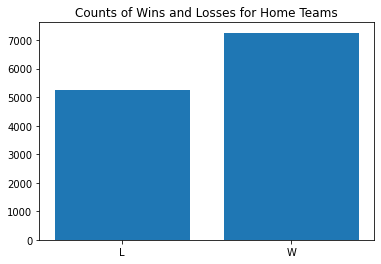

In [ ]:
import matplotlib.pyplot as plt

counts = [val.asDict().get("Win Loss Counts for Home Team") for val in res1.select("Win Loss Counts for Home Team").collect()]
wl = [val.asDict().get("WL_HOME") for val in res1.select("WL_HOME").collect()]

plt.bar(wl, counts)
plt.title("Counts of Wins and Losses for Home Teams")
plt.show()

Next, we have the averages for free throws and fouls for both the home and away team. Here, we can also see that over the thousands of games in this subset of the data, the home team has a higher average of free throws attempted and has less fouls called on them. With such a large sample, this difference is certainly significant.

In [ ]:
res2.show()

+------------------+------------------+-----------------+------------------+
|  Home Free Throws|  Away Free Throws|       Home Fouls|        Away Fouls|
+------------------+------------------+-----------------+------------------+
|23.227613129381773|22.338113448056088|19.82703951561504|20.442399617590823|
+------------------+------------------+-----------------+------------------+



Here we have another bar plot to show the difference in the averages of free throws and fouls for the home and away team.

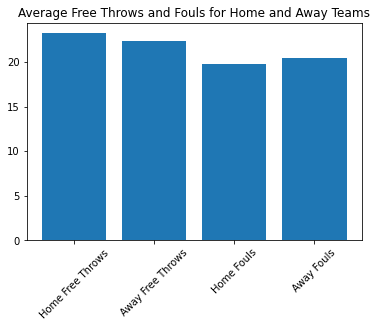

In [ ]:
keys = res2.collect().pop().asDict().keys()
vals = res2.collect().pop().asDict().values()

plt.bar(keys, vals)
plt.title("Average Free Throws and Fouls for Home and Away Teams")
plt.xticks(rotation = 45)
plt.show()

Looking at how the effects of home court advantage may change due to the games being nationally televised, we compare the win loss percentages for all games next to the nationally televised games. The win percentage is slightly better for nationally televised games. So the effect may be even stronger in nationally televised games.

In [ ]:
res1.join(res3, res1.WL_HOME == res3.WL_HOME).select(res1["WL_HOME"].alias("Result"), res1["Win Loss Percentage for Home Team"].alias("Percentage"), 
                                                     res3["Win Loss Percentage for Home Team"].alias("National TV Percentage")).show()

+------+-------------------+----------------------+
|Result|         Percentage|National TV Percentage|
+------+-------------------+----------------------+
|     L|0.41975703324808183|   0.40619240692959824|
|     W| 0.5802429667519181|    0.5938075930704018|
+------+-------------------+----------------------+



Looking at the win percentages for the home team for each broadcaster individually, we see that the win percentages are better for all the broadcasters with the exception of ESPN. That said, this win percentage is only slightly worse than the overall win percentage.

In [ ]:
res4.where(col("WL_HOME") == "W").select(col("NATL_TV_BROADCASTER_ABBR").alias("National TV Broadcaster"),
                                         col("GAME_COUNT").alias("Games Played"),
                                         col("WL_PCT").alias("Home Win Percentage")).show()

+-----------------------+------------+-------------------+
|National TV Broadcaster|Games Played|Home Win Percentage|
+-----------------------+------------+-------------------+
|                    ABC|         173| 0.5953757225433526|
|               ABC/ESPN|           1|                1.0|
|                   ALT2|           1|                1.0|
|                   ESPN|         837| 0.5758661887694145|
|                  ESPN2|           3| 0.6666666666666666|
|                 NBA TV|        1079| 0.6005560704355886|
|                    TNT|         612| 0.6111111111111112|
+-----------------------+------------+-------------------+



Looking at the win loss percentages for home and away teams and the difference between the two, we see that Portland, Denver and San Antonio have the largest differential, indicating that they may benefit the most from playing at home. In contrast, Pheonix, New Orleans (Hornets) and New Jersey (Nets) had the worst differential, indicating that they may have had the least benefit from playing at home.

In [ ]:
res7.show(n=10)

+----------------------+-------------+-------------+------------------+-------------------+-------------------+
|TEAM_ABBREVIATION_HOME|WL_COUNT_HOME|WL_COUNT_AWAY|       WL_PCT_HOME|        WL_PCT_AWAY|     HOME-AWAY DIFF|
+----------------------+-------------+-------------+------------------+-------------------+-------------------+
|                   POR|          278|          183|0.6634844868735084|0.43884892086330934|0.22463556601019902|
|                   DEN|          275|          182|0.6594724220623501|0.43855421686746987|0.22091820519488026|
|                   SAS|          315|          230|0.7664233576642335|  0.548926014319809| 0.2174973433444245|
|                   UTA|          262|          177|0.6390243902439025|0.42650602409638555| 0.2125183661475169|
|                   PHI|          227|          140|0.5417661097852029|0.33573141486810554|0.20603469491709736|
|                   DET|          211|          127|0.5059952038369304| 0.3060240963855422|0.19997110745

In [ ]:
res7.sort(col("HOME-AWAY DIFF"), ascending=True).show(n=10)

+----------------------+-------------+-------------+-------------------+-------------------+-------------------+
|TEAM_ABBREVIATION_HOME|WL_COUNT_HOME|WL_COUNT_AWAY|        WL_PCT_HOME|        WL_PCT_AWAY|     HOME-AWAY DIFF|
+----------------------+-------------+-------------+-------------------+-------------------+-------------------+
|                   PHX|          190|          150|0.45454545454545453| 0.3614457831325301|0.09309967141292441|
|                   NOH|           42|           33|0.42857142857142855| 0.3333333333333333|0.09523809523809523|
|                   NJN|           22|           15| 0.3728813559322034|0.26785714285714285|0.10502421307506055|
|                   CHI|          233|          187| 0.5600961538461539| 0.4506024096385542|0.10949374420759966|
|                   SAC|          179|          134| 0.4387254901960784| 0.3175355450236967|0.12118994517238174|
|                   LAL|          214|          160| 0.5169082125603864| 0.3883495145631068|0.12

# Conclusion

Not surprisingly, we can clearly see that there is a significant advantage of playing at home. Win percentages across the league in all games, local and nationally broadcast, for every team are better for the home team. With slightly better win percentages in nationally broadcast games, it may be the case that home court advantage is even more glaring when the pressure is greater and the entire country is watching. This effect is also certainly different depending on the team. While every team has better win percentages at home than away, the difference in those percentages vary greatly between all the teams. This would indicate that there is something to the theory that team's home stadiums and fanbases have varying levels of impact on their teams success at home. 

Another common theory is that referees call games differently for home teams. With the home team having more free throws on average and less fouls called on them on average, this theory would seem to be somewhat true. Although the difference in the averages may seem minor, with a sample size of over ten thousand games, this difference is likely statistically significant. 

Overall, in all areas of the data that we observed, there is a strong indication that there is a significant advantage of playing at home.